In [2]:
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist


Maximo de audio 0.17657470703125 y min de -0.164581298828125


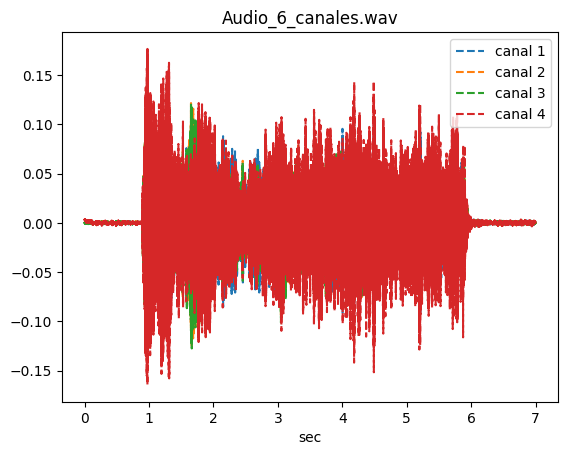

In [ ]:
# 1. Cargar el archivo de audio con librosa en formato multicanal (sin mono)
audio, sr = librosa.load('Audio_6_canales.wav', sr=None, mono=False)

# 2. Seleccionar los canales y el rango de tiempo deseado
#audio = audio[1:5,(0+26)*sr:(0+35)*sr]
#audio = audio[1:5,(60+40)*sr:(60+47)*sr]
audio = audio[1:5,6*sr:12*sr]


print(f"Maximo de audio {np.max(audio)} y min de {np.min(audio)}")

# 3. Graficar los canales seleccionados
x = np.arange(len(audio[0])) / sr
plt.plot(x, np.transpose(audio), '--')
plt.title("Audio_6_canales.wav")
plt.xlabel("sec")
plt.legend(["canal 1", "canal 2", "canal 3", "canal 4"])
plt.show()


Geometria del disenyo

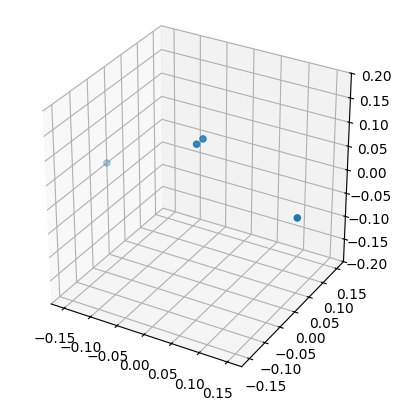

In [10]:
mic_pos = np.array([[-0.175, 0, 0], [0, 0.01, 0.1], [0, -0.01, 0.1], [0.175, 0, 0]])
margen_distancia = 0.1 #metros
margen_tau = math.ceil((margen_distancia / 343.0) * sr)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', box_aspect=[1, 1, 1])

# Definir los límites de los ejes para que x e y sean iguales
max_range = np.max(np.abs(mic_pos[:, :2]))  # Solo considerar x e y para el rango
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-0.2, 0.2])  # Ajuste el límite z según los datos específicos

# Graficar los puntos
ax.scatter(mic_pos[:, 0], mic_pos[:, 1], mic_pos[:, 2])
plt.show()


In [8]:
def max_tau(mic_pos, fs, margen_tau, hop_length):
    # Calcula todas las distancias entre los puntos
    distances = pdist(mic_pos)
    print(distances)
    # Calcula el máximo retardo en muestras para cada par de puntos y se le añade un pequeño margen para no pillarnos los dedos
    max_delays = max(np.round(distances / 343.0 * fs).astype(int)) + margen_tau  # Velocidad del sonido: 343 m/s
    max_delays = math.ceil(max_delays/hop_length)# + margen_tau

    return max_delays



In [66]:
def gcc_phat_pairwise(audio, delay_max_muestras):
    # Calcula la GCC-PHAT entre pares de canales
    num_channels = audio.shape[0]
    gcc_phat_pairs = []

    for i in range(num_channels):
        for j in range(i+1, num_channels):
            # Combina los canales para formar pares
            audio_pair = np.vstack((audio[i, :], audio[j, :]))

            # Calcula la STFT de librosa para cada par de canales
            #Se calcula el fft enventanado para ver como evoluciona la freq a lo largo del tiempo
            stft_mic1 = librosa.stft(audio_pair[0, :], n_fft=nfft_lenght, hop_length=hop_length)
            stft_mic2 = librosa.stft(audio_pair[1, :], n_fft=nfft_lenght, hop_length=hop_length)

            # Calcula la GCC-PHAT
            cross_corr = stft_mic1 * np.conj(stft_mic2)
            gcc_phat = cross_corr / np.abs(cross_corr)
            gcc_phat = np.fft.irfft(gcc_phat)

            #Quita las comillas para ver como queda por cada par de micros+
            """plt.title("GCC-PHAT sin enventanar")
            plt.imshow(gcc_phat)
            plt.show()"""


            # Como el GCC-PHAT en su mayoría no da informacion, enventanamos entre el punto central (no hay delay) a una distancia maxima de delay posible
            # Este delay maximo viene dado por la posicion de los micrófonos
            #[R_0, R_1, ..., R_(N/2-1), R_-N/2, ..., R_-1] (irfft)
            """gcc_phat= np.concatenate(
                    [ 
                        gcc_phat[50:, -delay_max_muestras :],
                        gcc_phat[50:, : delay_max_muestras],
                    ],
                    axis=-1,
                )"""
            
            #Se van añadiendo a medida que saca el GCC-PHAT entre micrófonos
            gcc_phat_pairs.append(gcc_phat)

    return np.array(gcc_phat_pairs)


hop_length = math.ceil(1*sr)
nfft_lenght = math.ceil(2*sr) 

delay_max = max_tau(mic_pos, sr, margen_tau, hop_length)
Espectrogramas =  gcc_phat_pairwise(audio,delay_max)

[0.20180436 0.20180436 0.35       0.02       0.20180436 0.20180436]


In [7]:
def create_sinusoidal_signals(frequency, sample_rate, duration, delay_samples):
    # Genera una señal sinusoidal en dos "micrófonos" con un desfase
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    signal_1 = 0.3**t*np.sin(2 * np.pi * frequency * t)
    signal_2 = np.roll(signal_1, delay_samples)  # Aplica un desfase en muestras
    signal_3 = np.roll(signal_1, -delay_samples)
    # Junta las señales en un array de dos canales (simulando dos micrófonos)
    audio = np.vstack((signal_1, signal_2, signal_3))
    return audio

# Parámetros de la señal de prueba
frequency = 440  # Frecuencia del tono, en Hz (440 Hz es la frecuencia de LA)
sample_rate = 16000  # Frecuencia de muestreo, en Hz
duration = 2  # Duración de la señal en segundos
delay_samples = 50  # Desfase en muestras (cambiar para ajustar el retardo)

# Genera las señales
#audio = create_sinusoidal_signals(frequency, sample_rate, duration, delay_samples)
#plt.plot(audio[0])
#plt.show()

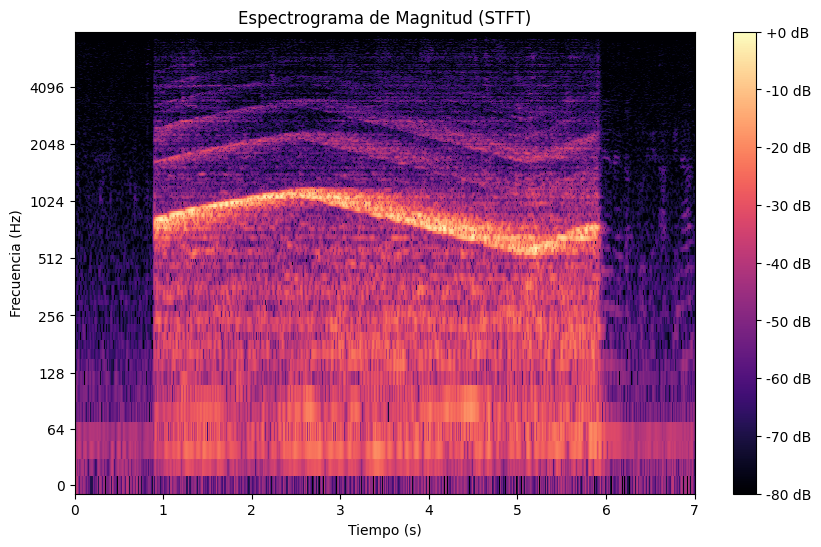

In [26]:
audio_pair = np.vstack((audio[0, :], audio[3, :]))
# Calcula la STFT de librosa para cada par de canales
#Se calcula el fft enventanado para ver como evoluciona la freq a lo largo del tiempo
stft_mic1 = librosa.stft(audio_pair[0, :], n_fft=nfft_lenght, hop_length=hop_length)
stft_mic2 = librosa.stft(audio_pair[1, :], n_fft=nfft_lenght, hop_length=hop_length)



# Visualizar la STFT
stft_db = librosa.amplitude_to_db(np.abs(stft_mic1), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(stft_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Magnitud (STFT)')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia (Hz)")
plt.show()

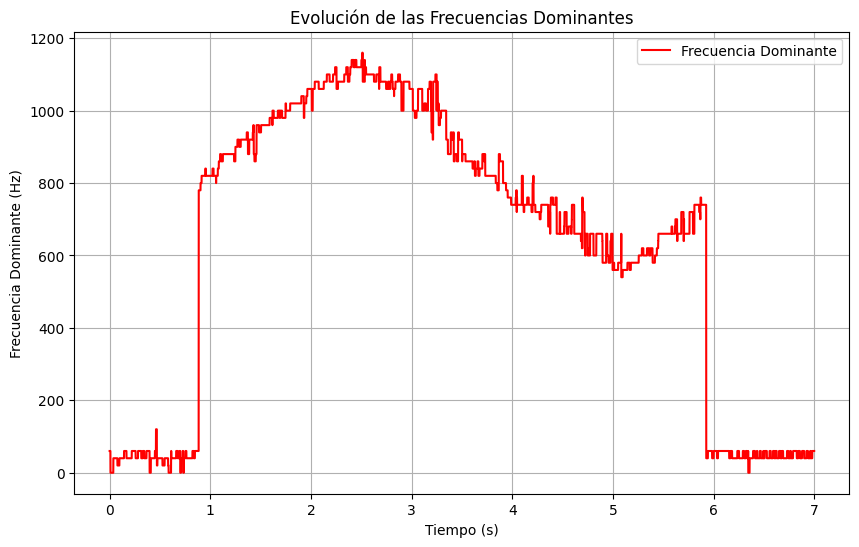

[920. 920. 920. ...  60.  60.  60.]


In [27]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Calcula las frecuencias dominantes
def get_dominant_frequencies(stft_matrix, sr, hop_length, n_fft):
    """
    Encuentra las frecuencias dominantes a lo largo del tiempo en una STFT.

    Args:
        stft_matrix (np.ndarray): Matriz de STFT (frecuencia x tiempo).
        sr (int): Frecuencia de muestreo (Hz).
        hop_length (int): Número de muestras entre ventanas consecutivas.
        n_fft (int): Tamaño de la FFT.

    Returns:
        tuple: Frecuencias dominantes (Hz) y tiempos (s).
    """
    # Magnitud de la STFT
    magnitude = np.abs(stft_matrix)

    # Índices de las frecuencias dominantes por cada ventana de tiempo
    dominant_indices = np.argmax(magnitude, axis=0)

    # Calcula las frecuencias correspondientes (Hz)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    dominant_frequencies = freqs[dominant_indices]

    # Calcula los tiempos correspondientes (s)
    times = librosa.frames_to_time(np.arange(magnitude.shape[1]), sr=sr, hop_length=hop_length)

    return dominant_frequencies, times

# Usamos la función con tu STFT
dominant_frequencies, times = get_dominant_frequencies(stft_mic1, sr=sr, hop_length=hop_length, n_fft=nfft_lenght)

# Visualizar las frecuencias dominantes
plt.figure(figsize=(10, 6))
plt.plot(times, dominant_frequencies, label="Frecuencia Dominante", color='r')
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia Dominante (Hz)")
plt.title("Evolución de las Frecuencias Dominantes")
plt.grid()
plt.legend()
plt.show()
print(dominant_frequencies[len(dominant_frequencies)//2:])


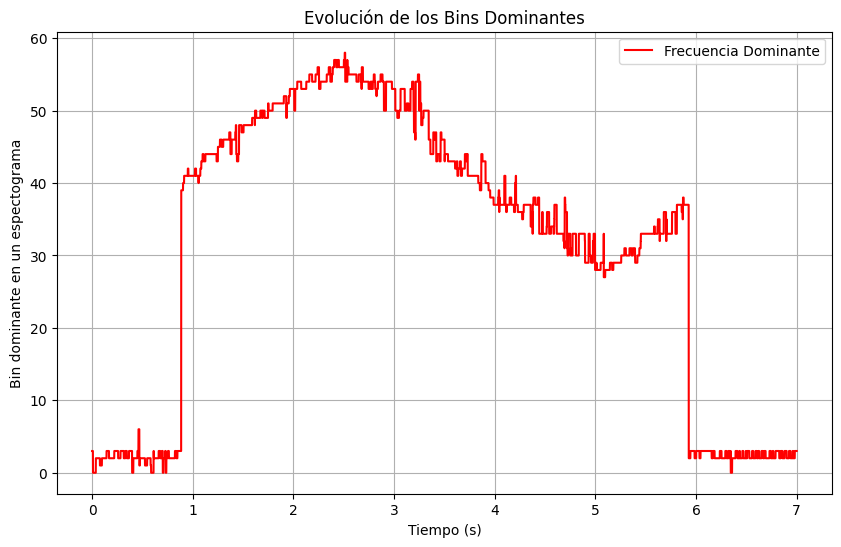

In [28]:
def frequencies_to_bins(frequencies, sr, n_fft):
    """
    Convierte un array de frecuencias a los bins correspondientes en un espectrograma.

    Args:
        frequencies (np.ndarray): Array de frecuencias (Hz).
        sr (int): Frecuencia de muestreo (Hz).
        n_fft (int): Tamaño de la FFT.

    Returns:
        np.ndarray: Índices de los bins correspondientes.
    """
    # Resolución espectral
    delta_f = sr / n_fft
    # Convertir frecuencias a bins
    bins = np.floor(frequencies / delta_f).astype(int)

    return bins


bins_array = frequencies_to_bins(dominant_frequencies,sr,nfft_lenght)
# Visualizar las frecuencias dominantes
plt.figure(figsize=(10, 6))
plt.plot(times, bins_array, label="Frecuencia Dominante", color='r')
plt.xlabel("Tiempo (s)")
plt.ylabel("Bin dominante en un espectograma")
plt.title("Evolución de los Bins Dominantes")
plt.grid()
plt.legend()
plt.show()


[0.20180436 0.20180436 0.35       0.02       0.20180436 0.20180436]
11


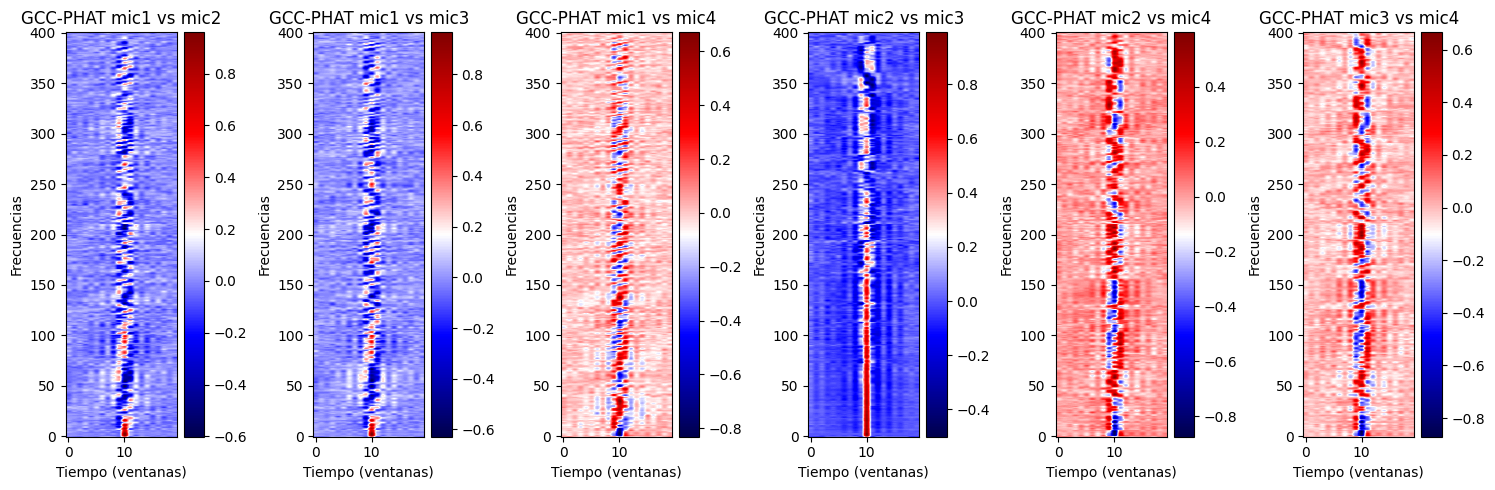

(401, 20)


In [29]:
def gcc_phat_pairwise(audio, delay_max_muestras, nfft_length, hop_length):
    # Calcula la GCC-PHAT entre pares de canales
    num_channels = audio.shape[0]
    num_pairs = (num_channels * (num_channels - 1)) // 2  # Número de pares únicos
    fig, axs = plt.subplots(1, num_pairs, figsize=(15, 5))  # Crear subplots en una fila
    gcc_phat_pairs = []
    pair_index = 0  # Índice para el subplot

    for i in range(num_channels):
        for j in range(i + 1, num_channels):
            # Combina los canales para formar pares
            audio_pair = np.vstack((audio[i, :], audio[j, :]))

            # Calcula la STFT de cada canal en el par
            stft_mic1 = librosa.stft(audio_pair[0, :], n_fft=nfft_length, hop_length=hop_length)
            stft_mic2 = librosa.stft(audio_pair[1, :], n_fft=nfft_length, hop_length=hop_length)

            # Calcula la GCC-PHAT
            cross_corr = stft_mic1 * np.conj(stft_mic2)
            gcc_phat = cross_corr / np.abs(cross_corr)
            gcc_phat = np.fft.irfft(gcc_phat)

            # Enventanado: tomamos la región alrededor del centro con el retraso máximo
            gcc_phat_windowed = np.concatenate(
                    [ 
                        gcc_phat[:, -delay_max_muestras :],
                        gcc_phat[:, : delay_max_muestras],
                    ],
                    axis=-1,
                )
            # Visualización de GCC-PHAT enventanado
            axs[pair_index].imshow(gcc_phat_windowed, aspect='auto', origin='lower', cmap='seismic')
            axs[pair_index].set_title(f"GCC-PHAT mic{i+1} vs mic{j+1}")
            axs[pair_index].set_xlabel("Tiempo (ventanas)")
            axs[pair_index].set_ylabel("Frecuencias")
            plt.colorbar(axs[pair_index].images[0], ax=axs[pair_index])  # Barra de color para cada subplot

            # Guarda el resultado enventanado en la lista
            gcc_phat_pairs.append(gcc_phat_windowed)
            pair_index += 1

    plt.tight_layout()
    plt.show()

    return np.array(gcc_phat_pairs)


# Parámetros de ejemplo
hop_length = math.ceil(0.0001*sr)
nfft_lenght = math.ceil(0.05*sr) 

delay_max = max_tau(mic_pos, sr, margen_tau, hop_length)
print(delay_max)
Espectrogramas =  gcc_phat_pairwise(audio,10,nfft_lenght,hop_length)
print(Espectrogramas[0].shape)


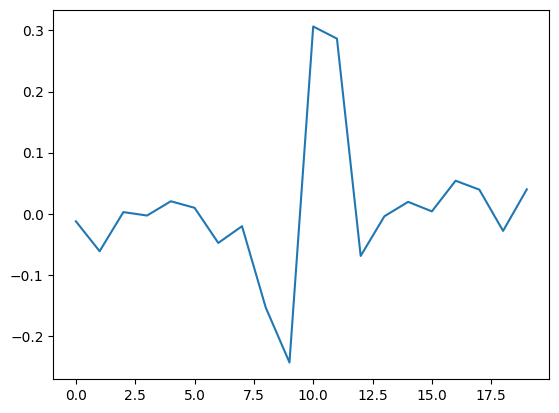

In [24]:
def get_first(Espectrograma,bins_array):
    bins, hops = Espectrograma.shape
    results = []
    for bin in bins_array:  
        maximo = np.max(Espectrograma[bin])
        minimo = np.min(Espectrograma[bin])
        result = 1 if (maximo > abs(minimo))  else -1
        results.append(result)
    
    #plt.plot(results)
plt.plot(Espectrogramas[3,110,:])
get_first(Espectrogramas[3],bins_array)
